# Analysis File for calcium imaging analysis, basic analysis

In [1]:
# import packages
#https://pandas.pydata.org/docs/user_guide/index.html
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from numpy import trapz
from scipy.stats import zscore

In [2]:
def preprocess_logs(logs, path):
    """preprocess the log files to return a table with the ratios for Calcium Imaging"""
    before_string = "string"
    columns = None
    list_tables = []
    with open(logs) as file:
        lines = file.readlines()
        for line in lines:
            try: 
                if ("Time" in line) & ("Region" in before_string):
                    data = line.split(",")
                    data = [i.replace('"', "") for i in data]
                    columns = data
                    before_string = "None"
                    
                elif before_string == "None":
                    data = line.split(",")
                    try:
                        data = [float(i) for i in data]
                        list_tables.append(data)
                    except Exception as e:
                        print(e)
                else:
                    before_string = line.split()[0]
                    
            except Exception as e:
                print(e)
    print(f"Succesfully run through file {logs}")            
    return pd.DataFrame(list_tables, columns = columns).drop("Time (sec)", axis = 1)

def open_function_save_dataframe(files, path):
    """ get the dataframe from the file and append to list"""
    list_dataframe = []
    for i in files:
        dataframe = preprocess_logs(i, path)
        list_dataframe.append(dataframe)
        
    return list_dataframe


def calculate_ratio(dataframe, time_filter):
    """
    Calculate the ratios between the 340 and 380 wavelength
    input:
        dataframe type(list of dataframe)
    return 
        dataframe type(dataframe) -> background corrected ratios
    """
    ratios = []
    for i in dataframe:
        background_1 = i.iloc[:,-2]
        background_2 = i.iloc[:,-1]
        i = i.iloc[:,:-4]
        try: 
            for ratio_1, ratio_2 in zip(range(0, 30 * 2, 2), range(1, 30 * 2, 2)):
                background = background_1/background_2
                ratio =  (i.iloc[:, ratio_1]-background_1)/(i.iloc[:,ratio_2]-background_2)
                #ratio =  (i.iloc[:, ratio_1])/(i.iloc[:,ratio_2])
                if ratio.shape[0] < time_filter:
                    continue
                ratios.append(ratio.tolist())
    
        
        except Exception as e: 
            print("Index to long nothing to worry")
            print(e)
           
    # invert the dataframe                   
    dataframe = pd.DataFrame(ratios).T
    return dataframe     

def filter_table_based_on_potassium(table):
    potassium_boundaries = (540,550)
    index_columns = []
    for index, column in enumerate(table.columns):
        all_value = table[column].values
        max_value = trapz((all_value[potassium_boundaries[0]: potassium_boundaries[1]]), dx = 5)
        if max_value < 4:
            index_columns.append(index)
    dataframe_columns_to_drop = table.columns[index_columns]
    print(dataframe_columns_to_drop)
    final_table = table.drop(dataframe_columns_to_drop, axis = 1)
    
    return final_table  


################################################
# change timings
###############################################
def area_under_the_curve(dataframe):
    """ calculate the area under the curve """
    area_dicationary = {}
    max_dicationary = {}
    
    #############################################
    # please set here the timepoint for the condition
    baseline = (0,10)
    solvent_small = (60,70)
    solvent_large = (180,190)
    trep_small = (300,310)
    trep_large = (420,430)
    potassium = (540,550)
    #############################################
    
    list_of_boundaries = [baseline, solvent_small, solvent_large, trep_small, trep_large, potassium]
    list_of_names = ["baseline", "solvent_0.02", "solvent_0.5", "trep_0.02", "trep_0.5", "potassium_20mM"]
    
    # loop through the boundaries and the names
    for boundary, names in zip(list_of_boundaries, list_of_names):
        area_under_the_curve = []
        max_values_list = []
        for column in dataframe.columns:
            area_curve = dataframe[column].values
            area_curve = area_curve[boundary[0]:boundary[1]]
            area = trapz(area_curve, dx=5)
            max_value = np.amax(area_curve)
            area_under_the_curve.append(area)
            max_values_list.append(max_value)
            
        area_dicationary.update({names: area_under_the_curve})
        max_dicationary.update({names: max_values_list})
        
    print("succesfully calculate peak and area under the curve")
    return area_dicationary, max_dicationary

def calculate_area_and_max(calcium_imaging):
    """ calculate the area under the curve and the max peak value 
    for the filtered results obtained in the cell before
    
    args:
        calcium_imaging <- filtered table
    return
        plot of area under the curve and max
    """
    area_value, max_value = area_under_the_curve(calcium_imaging)
    area = pd.DataFrame(area_value)
    area_melt = pd.melt(area)
    maximum = pd.DataFrame(max_value)
    max_melt = pd.melt(maximum)
    fig, ax = plt.subplots(figsize = (14,7), ncols = 2, nrows = 2)
    sns.despine()
    sns.kdeplot(data = maximum, shade = True, ax = ax[1,1], legend = False)
    ax[1,1].set_title("Peak Value Density")
    sns.kdeplot(data = area, shade = True, ax = ax[1,0])
    ax[1,0].set_title("AUC Density")
    
    # draw the boxplot and swarmplot
    sns.boxplot(data = area_melt, x = "variable", y = "value", palette = "tab20b",ax = ax[0,0])
    sns.swarmplot(data = area_melt, x = "variable", y = "value", palette = "tab20b", ax = ax[0,0])
    ax[0,0].set_title("AUC Comparison")
    sns.boxplot(data = max_melt, x = "variable", y = "value", ax = ax[0,1])
    sns.swarmplot(data = max_melt, x = "variable", y = "value", linewidth = 1, ax = ax[0,1])
    ax[0,1].set_title("Peak Comparison")
    # plot the title
    plt.title("Density estimation of peak value")
    plt.tight_layout()
    plt.savefig("area_max_figure.pdf", dpi = 500, bbox_inches = "tight")
    return ax
    
def draw_all_traces(calcium_imaging):
    """ draw all calcium traces indivdual ones
    """
    calcium = calcium_imaging.reset_index()
    melted_table = calcium.melt(id_vars = "index")
    fig,ax = plt.subplots(figsize = (7,5))
    sns.despine()
    sns.lineplot(data = melted_table, x = "index" , y = "value", hue = "variable", legend = False, palette = "tab20b")
    plt.ylabel("340/385 ratios")
    plt.xlabel("time")
    plt.title(f"Number of cells measure: {calcium_imaging.shape[1]}")
    plt.savefig("all_traces_analysis.pdf", dpi = 500, bbox_inches = "tight")
    return ax
    


def calculate_mean_curve(calcium_imaging):
    """ calculate the average curve
    """
    #calcium_imaging = calcium_imaging.reset_index()
    calcium_imaging["mean"] = calcium_imaging.mean(axis = 1)
    calcium_imaging["sem"] = calcium_imaging.sem(axis = 1)

    x = calcium_imaging.index
    y_mean = calcium_imaging["mean"].tolist()
    lower = calcium_imaging["mean"] - calcium_imaging["sem"].tolist()
    upper = calcium_imaging["mean"] + calcium_imaging["sem"].tolist()

    fig, ax = plt.subplots(figsize=(9,5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #draw the boundaries
    ax.plot(x, y_mean, label='signal mean')
    ax.plot(x, lower, color='tab:grey', alpha=0.1)
    ax.plot(x, upper, color='tab:grey', alpha=0.1)

    #fill the boundaries
    ax.fill_between(x, lower, upper, alpha=0.2, color = "purple")
    ax.set_xlabel('Recorded Time')
    ax.set_ylabel('Normalized 340/385 ratio')
    #plt.ylim(-0.8,1)
    plt.savefig("mean_traces_analysis.pdf", dpi = 500, bbox_inches = "tight")
    return ax

Succesfully run through file M1.LOG
Succesfully run through file M10.LOG
Succesfully run through file M3.LOG
Succesfully run through file M6.LOG
Succesfully run through file M7.LOG
Succesfully run through file M8.LOG
Succesfully run through file M9.LOG
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Index to long nothing to worry
single positional indexer is out-of-bounds
Int64Index([9, 12, 18, 19, 22, 32, 33, 34, 36, 43], dtype='int64')
succesfully calculate peak and area under the curve


C:\Users\q102cs\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\q102cs\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\q102cs\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


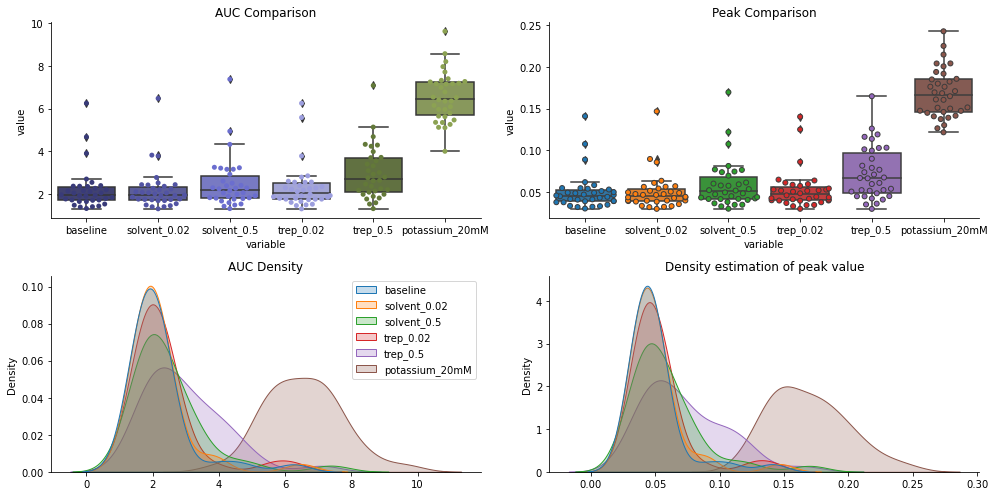

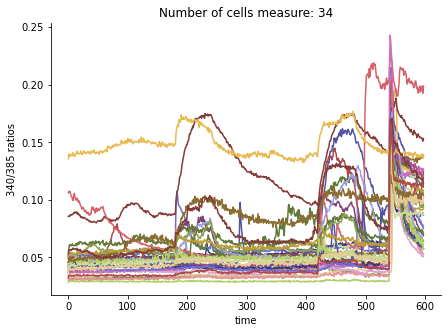

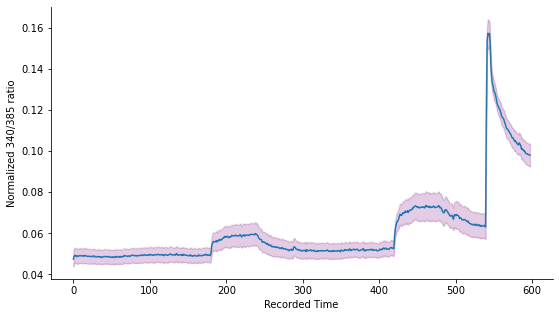

In [3]:
# Put log files in the folder of the Notebook
# Log files should end with .LOG

#set path correctly and ensure all files are log files
path = r"C:\Users\q102cs\Desktop\AOP MESUUNG 19_20_7_22 TEXTFILES\DIV1"
os.chdir(path)
analysis_files = sorted([i  for i in os.listdir() if ".LOG" in i])

# set time filter correctly for length of experiment
time_filter = 590

# let the functions run
calcium_dataframe = open_function_save_dataframe(analysis_files, path)
calcium_imaging= calculate_ratio(calcium_dataframe, time_filter)
calcium_imaging_filtered = filter_table_based_on_potassium(calcium_imaging.iloc[:-2,:])
area_figure = calculate_area_and_max(calcium_imaging_filtered)
single_traces_figure = draw_all_traces(calcium_imaging_filtered)
mean_trace_figure = calculate_mean_curve(calcium_imaging_filtered)